# Overview
Use this notebook to convert an OCT image to virtual histology.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/ConvertOCTImagesToHistology.ipynb) and run.

## Notebook's Inputs:

In [1]:
# Path to the OCT image
#cropping parameters:
width = 256 * 4
height = 256 * 2
x0 = 135
z0= 350
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LG-19 - Slide04_Section02 (Fig 3.c)/OCTAligned.tiff"

# OCT image's pixel size
microns_per_pixel_z = 1
microns_per_pixel_x = 1

## Set Up Environment

In [2]:
if not 'setup_env_oct2Hist_usemodel' in globals():
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel
  %run /content/OCT2Hist-UseModel/setup_env.ipynb
  setup_env_oct2Hist_usemodel = True
from utils.show_images import *
from utils.crop import crop
from utils.masking import mask_image
import cv2
import matplotlib.pyplot as plt
import numpy as np

Cloning into 'OCT2Hist-UseModel'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 267 (delta 69), reused 55 (delta 15), pack-reused 156
Receiving objects: 100% (267/267), 8.79 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 35.56 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
Mounted at /content/drive/
/content/OCT2Hist-UseModel
Drive already mounted at /content/drive/;

## Preprocess
In this step we load the OCT image, then perform preprocessing.
Preprocessing is designed to convert the standard OCT image to the format that our pre-trained OCT2Hist model can work with.

Preprocessing steps are
1.   **Mask** - Remove areas of low signal to noise or gel.
2.   **Crop** - Native OCT images can be too big for the OCT2Hist model to run on
3.   **Resolution Matching** - OCT2Hist works on OCT images at specific resolution (microns per pixel). make sure that OCT image matches resolution.



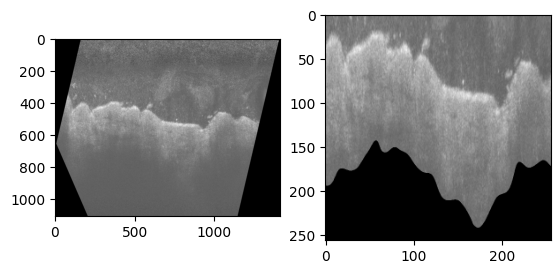

In [3]:
# Load OCT image
oct_image_orig = cv2.imread(oct_input_image_path)
oct_image_orig = cv2.cvtColor(oct_image_orig, cv2.COLOR_BGR2RGB)
oct_image = oct_image_orig.copy()

# Mask
masked_image, filt_img = mask_image(oct_image)

# Crop
cropped = crop(masked_image)

# Resolution Matching
o2h_input = cv2.resize(cropped, [256,256] , interpolation=cv2.INTER_AREA)

# Visualize pre-processing results (before - left, after preprocessing - right)
showTwoImgs(oct_image_orig, o2h_input)

## Run Model

In [4]:
virtual_histology_image = pix2pix.run_network(o2h_input)

## Post Process ##
In this step we undo resolution matching to bring the histology image output back to the resolution of the OCT and present results to user

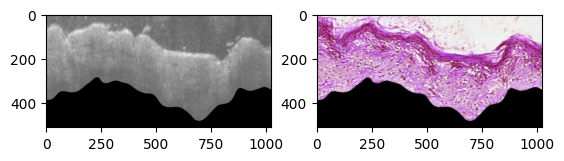

In [5]:
height,width = cropped.shape[:2]
virtual_histology_image_resized = cv2.resize(virtual_histology_image, [width,height] , interpolation=cv2.INTER_AREA)
showTwoImgs(cropped, virtual_histology_image_resized)